In [2]:
#unzipping the data into colab
!unzip face_data
%ls

Streaming output truncated to the last 5000 lines.
  inflating: face_crop/003812_1.jpg  
  inflating: face_crop/003812_2.jpg  
  inflating: face_crop/003813_1.jpg  
  inflating: face_crop/003814_1.jpg  
  inflating: face_crop/003815_1.jpg  
  inflating: face_crop/003816_1.jpg  
  inflating: face_crop/003817_1.jpg  
  inflating: face_crop/003818_1.jpg  
  inflating: face_crop/003820_1.jpg  
  inflating: face_crop/003820_2.jpg  
  inflating: face_crop/003820_3.jpg  
  inflating: face_crop/003821_1.jpg  
  inflating: face_crop/003822_1.jpg  
  inflating: face_crop/003823_1.jpg  
  inflating: face_crop/003824_1.jpg  
  inflating: face_crop/003825_1.jpg  
  inflating: face_crop/003825_2.jpg  
  inflating: face_crop/003826_1.jpg  
  inflating: face_crop/003827_1.jpg  
  inflating: face_crop/003828_1.jpg  
  inflating: face_crop/003828_2.jpg  
  inflating: face_crop/003829_1.jpg  
  inflating: face_crop/003830_1.jpg  
  inflating: face_crop/003831_1.jpg  
  inflating: face_crop/003832_1.jpg  

In [5]:
#removing extra images
import os

file_path = "/content/face_crop_segmentation/c.jpg"  # Change to the correct file path

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted: {file_path}")
else:
    print("File not found!")

file_path = "/content/face_crop/000601_1.jpg"  # Change to the correct file path

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Deleted: {file_path}")
else:
    print("File not found!")


File not found!
File not found!


In [6]:
# removing unnecessary files
!rm -rf /content/face_crop/.ipynb_checkpoints

In [ ]:
# !pip install torch torchvision opencv-python numpy matplotlib scikit-learn

In [ ]:
# !pip uninstall torch -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # For GPU

In [7]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [8]:
#defining dataset paths
import os

image_dir = "/content/face_crop" #this directory has images of faces with masks
mask_dir = "/content/face_crop_segmentation" #this directory has images in which the masks have been segmented from the corresponding images in the above folder

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

print(f"Total Images: {len(image_files)}, Total Masks: {len(mask_files)}")

# Check for mismatched files
for img, mask in zip(image_files, mask_files):
    if img.split(".")[0] != mask.split(".")[0]:  # Check filename match
        print(f"Mismatch: {img} <--> {mask}")


Total Images: 9382, Total Masks: 9382


In [9]:
#importing necessary libraries
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt


# Data Generator Class for Efficient Loading
class DataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=16, img_size=(128, 128)):
        self.image_filenames = sorted(os.listdir(image_dir))  # Ensure matching order
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.indexes = np.arange(len(self.image_filenames))

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_masks = [], []

        for i in batch_indexes:
            img_path = os.path.join(self.image_dir, self.image_filenames[i])
            mask_path = os.path.join(self.mask_dir, self.mask_filenames[i])

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                continue  # Skip corrupted images

            # Ensure both images and masks are resized correctly
            img = cv2.resize(img, self.img_size) / 255.0
            mask = cv2.resize(mask, self.img_size) / 255.0  # Ensure correct size
            mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

            batch_images.append(img)
            batch_masks.append(mask)

        return np.array(batch_images), np.array(batch_masks)

# U-Net Model
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), padding='same')(inputs)
    c1 = LeakyReLU(alpha=0.1)(c1)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), padding='same')(c1)
    c1 = LeakyReLU(alpha=0.1)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.3)(p1)

    c2 = Conv2D(64, (3, 3), padding='same')(p1)
    c2 = LeakyReLU(alpha=0.1)(c2)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), padding='same')(c2)
    c2 = LeakyReLU(alpha=0.1)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(128, (3, 3), padding='same')(p2)
    c3 = LeakyReLU(alpha=0.1)(c3)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, (3, 3), padding='same')(c3)
    c3 = LeakyReLU(alpha=0.1)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.3)(p3)

    # Bottleneck
    c4 = Conv2D(256, (5, 5), padding='same')(p3)  # Larger kernel at deeper layers
    c4 = LeakyReLU(alpha=0.1)(c4)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, (5, 5), padding='same')(c4)  # Larger kernel
    c4 = LeakyReLU(alpha=0.1)(c4)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    m5 = Concatenate()([u5, c3])
    c5 = Conv2D(128, (3, 3), padding='same')(m5)
    c5 = LeakyReLU(alpha=0.1)(c5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(128, (3, 3), padding='same')(c5)
    c5 = LeakyReLU(alpha=0.1)(c5)

    u6 = UpSampling2D((2, 2))(c5)
    m6 = Concatenate()([u6, c2])
    c6 = Conv2D(64, (3, 3), padding='same')(m6)
    c6 = LeakyReLU(alpha=0.1)(c6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(64, (3, 3), padding='same')(c6)
    c6 = LeakyReLU(alpha=0.1)(c6)

    u7 = UpSampling2D((2, 2))(c6)
    m7 = Concatenate()([u7, c1])
    c7 = Conv2D(32, (3, 3), padding='same')(m7)
    c7 = LeakyReLU(alpha=0.1)(c7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(32, (3, 3), padding='same')(c7)
    c7 = LeakyReLU(alpha=0.1)(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Creating data generators
batch_size = 16
train_generator = DataGenerator(image_dir, mask_dir, batch_size=batch_size)
val_generator = DataGenerator(image_dir, mask_dir, batch_size=batch_size)

# Compiling model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

# Training the model
model.fit(train_generator, validation_data=val_generator, epochs=7)

# Saving the Model
model.save("/content/unet_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 92s 119ms/step - accuracy: 0.5631 - loss: 0.2717 - val_accuracy: 0.6001 - val_loss: 0.1524
Epoch 2/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 127s 118ms/step - accuracy: 0.6052 - loss: 0.1361 - val_accuracy: 0.6108 - val_loss: 0.1150
Epoch 3/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 71s 121ms/step - accuracy: 0.6074 - loss: 0.1118 - val_accuracy: 0.6090 - val_loss: 0.1013
Epoch 4/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 72s 123ms/step - accuracy: 0.6108 - loss: 0.1002 - val_accuracy: 0.6132 - val_loss: 0.0909
Epoch 5/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 71s 121ms/step - accuracy: 0.6109 - loss: 0.0948 - val_accuracy: 0.6124 - val_loss: 0.0887
Epoch 6/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 70s 120ms/step - accuracy: 0.6159 - loss: 0.0886 - val_accuracy: 0.6151 - val_loss: 0.0800
Epoch 7/7
586/586 ━━━━━━━━━━━━━━━━━━━━ 71s 121ms/step - accuracy: 0.6114 - loss: 0.0841 - val_accuracy: 0.6158 - val_loss: 0.0807


In [10]:
# Loading Trained Model
model = tf.keras.models.load_model("/content/unet_model.h5")

# Predicting on Validation Data
Y_pred = model.predict(val_generator)
Y_pred = (Y_pred > 0.5).astype(np.uint8)  # Convert predictions to binary masks

# Computing IoU and Dice Score
def calculate_iou(y_true, y_pred):
    #Compute IoU score
    y_true = (y_true > 0.5).astype(np.uint8).flatten()
    y_pred = (y_pred > 0.5).astype(np.uint8).flatten()
    return jaccard_score(y_true, y_pred)

def dice_score(y_true, y_pred):
    #Compute Dice score
    y_true = (y_true > 0.5).astype(np.uint8).flatten()
    y_pred = (y_pred > 0.5).astype(np.uint8).flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)  # Avoid division by zero

# Computing Metrics Over All Batches
iou_scores, dice_scores = [], []

for i in range(len(val_generator)):
    y_true_batch = val_generator[i][1]  # Ground truth masks (batch)

    # Ensuring we extract the correct number of predictions
    y_pred_batch = Y_pred[i * len(y_true_batch): i * len(y_true_batch) + len(y_true_batch)]

    # print(f"Batch {i}: y_true shape: {y_true_batch.shape}, y_pred shape: {y_pred_batch.shape}")  # Debugging

    # Fix: Ensure both batches have the same size before looping
    min_samples = min(len(y_true_batch), len(y_pred_batch))

    for j in range(min_samples):  # Loop through batch elements safely
        iou_scores.append(calculate_iou(y_true_batch[j], y_pred_batch[j]))
        dice_scores.append(dice_score(y_true_batch[j], y_pred_batch[j]))

# Printing Final Metrics
print(f"U-Net Mean IoU: {np.mean(iou_scores):.4f}")
print(f"U-Net Mean Dice Score: {np.mean(dice_scores):.4f}")

# Prediction Function for a Single Image
def predict_mask(image_path, model, img_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size) / 255.0
    img = np.expand_dims(img, axis=0)

    pred_mask = model.predict(img)[0, :, :, 0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.imread(image_path))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.show()


586/586 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step
U-Net Mean IoU: 0.9206
U-Net Mean Dice Score: 0.9547


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


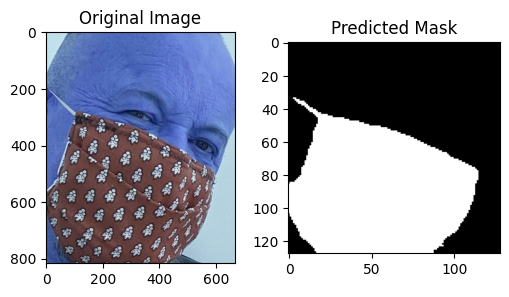

In [ ]:
# predicting for an example image
predict_mask("/content/face_crop/000100_1.jpg", model)